In [1]:
import numpy as np
import numpy.random as npr
import torch
from scipy.stats import multivariate_normal as mvn

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.special import expit as sigmoid
from tqdm import tnrange, tqdm_notebook

import svmc
from svmc.covfun import SquaredExponential
from svmc import SVMC_GP
from svmc import proposal
from svmc import likelihood
from svmc.dynamics import SGPDynamics as SGP

torch.set_default_dtype(torch.float64)  # GP dynamics are more numerically stable with 64 fp
randseed = 523

In [2]:
# RSLDS functions
def compute_leaf_log_prob(R, x, K, depth, leaf_paths):
    # Generate discrete latent states
    log_prob = np.zeros(K)
    for k in range(K):
        "Compute prior probabilities of each path"
        for level in range(depth - 1):
            node = int(leaf_paths[level, k])
            child = leaf_paths[level + 1, k]
            if not np.isnan(child):
                v = np.matmul(R[level][:-1, node - 1], x) + R[level][-1, node - 1]
                if int(child) % 2 == 1:  # If odd then you went left
                    log_prob[k] += np.log(sigmoid(v))
                else:
                    log_prob[k] += np.log(sigmoid(-v))
    return log_prob


def rslds_vector_field(A, B, R, r, xmin, xmax, ymin, ymax, delta, K):
    x, y = np.arange(xmin, xmax, delta), np.arange(ymin, ymax, delta)
    X, Y = np.meshgrid(x, y)
    points = np.zeros((X[:, 0].size, X[0, :].size, 2))
    points[:, :, 0] = X
    points[:, :, 1] = Y
    arrows = np.zeros(points.shape)
    
    v = np.zeros(K - 1)
    p = np.zeros(K)
    for row in range(X[:, 0].size):
        for col in range(X[0, :].size):
            pts = np.matrix( points[row, col,:] ).T
            for k in range(K - 1):
                v[k] = np.matrix(R[:, k]) * pts + r[k]

            "Compute weighted LDS"
            arrow = 0
            for k in range(K):
                w = 1
                #COmpute weight
                for j in range(k):
                    w *= sigmoid(-v[j])
                if k != K - 1:
                    w *= sigmoid(v[k])
                
                arrow += np.array( w*( np.matrix(A[:,:,k])*pts + np.matrix(B[:,k]).T ) ).flatten()
            
            arrows[row, col, :] = arrow-np.array(pts).flatten()

    u, v = arrows[:, :, 0], arrows[:, :, 1]
    # u = u.reshape(x.shape)
    # v = v.reshape(y.shape)
    speed = np.sqrt(u ** 2 + v ** 2)
    speed = (speed - speed.min()) / speed.max()

    fig = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    cs = ax.streamplot(X, Y, u, v, color=speed, cmap="coolwarm")
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_aspect("equal")
    
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(cs.lines, cax=cax, extend="both")
    
    cbar.ax.get_yaxis().set_ticks([])
    cbar.ax.get_yaxis().labelpad = 15
    cbar.ax.set_ylabel('high < speed > low', rotation=270)

    return fig


def gp_velocity_field(sgp, z_mean, z_cov, xlim, ylim, m=10, l=-8, u=8, fig=None, full_cov=False):
    lim = [l, u]
    xs = np.linspace(*lim, num=m)
    ys = np.linspace(*lim, num=m)
    x, y = np.meshgrid(xs, ys)
    xy = np.stack([x.ravel(), y.ravel()])

    dx, dx_cov = sgp.predict(xy.T, m=z_mean, G=z_cov, full_cov=full_cov)

    dx = dx.detach().numpy()
    dx_cov = dx_cov.detach().numpy()

    u, v = dx.T
    u = u.reshape(x.shape)
    v = v.reshape(y.shape)
    speed = np.sqrt(u ** 2 + v ** 2)
    speed = (speed - speed.min()) / speed.max()

    fig1 = plt.figure(figsize=(8, 6))
    ax = plt.gca()
    cs = ax.streamplot(x, y, u, v, color=speed, cmap="coolwarm")
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_aspect("equal")

    from mpl_toolkits.axes_grid1 import make_axes_locatable
        
    return fig1

Settings

In [3]:
d_latent = 2  # latent space dimensionality
d_obs = 50  # observation dimenionality
d_hidden = 10  # MLP proposal hidden units
m_inducing = 20  # number of GP inducing points
vary = 0.01  # variance of observation noise
varx = 1e-3  # variance of state noise

T1 = 2000  # length of training set
T2 = 500   # length of forecasting
n_pf = 50  # number of particles
n_optim = 5  # number of particles to compute ELBO for SGD
iter_optim = 5  # number of SGD iterations per step
lr = 1e-4  # learning rate
Tu = 50  # train GP after how many steps
log_flag = False
emission_grad = False

# GP hyperparameters
length_scale = 5.
fvar = 10.
gp_diffusion = 5.

We generate NASCAR the trajectory using the recurrent switching linear dynamical system (RSLDS). Let's load the parameters and draw the velocity field.

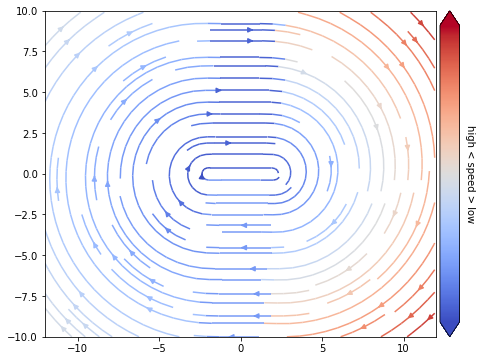

In [4]:
rslds_data = np.load("rslds_nascar.npy", allow_pickle=True)[()]
K = 4
dim = d_latent

Atrue = rslds_data['A']
btrue = rslds_data['b']
Rtrue = np.zeros((dim, K - 1))
Rtrue[0, 0] = 100
Rtrue[0, 1] = -100
Rtrue[1, 2] = 100
rtrue = -200*np.ones(K - 1)
rtrue[-1] = 0

xmin, xmax = -12, 12
ymin, ymax = -10, 10

fig = rslds_vector_field(A=Atrue, B=btrue, R=Rtrue, r=rtrue, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax, delta=0.1, K=K)

The function below implements the RSLDS.

In [5]:
def rslds(x, A, B, R, r, K, dx=False):
    v = np.zeros(K - 1)
    p = np.zeros(K)
    
    for k in range(K - 1):
        v[k] = R[:, k] @ x + r[k]

    "Compute weighted LDS"
    fx = 0
    for k in range(K):
        w = 1
        # Compute weight
        for j in range(k):
            w *= sigmoid(-v[j])
        if k != K - 1:
            w *= sigmoid(v[k])

        fx += w*(A[:,:,k] @ x + B[:,k])
    
    if dx:
        fx = fx - x
    
    return fx

Then we can generate the trajectory

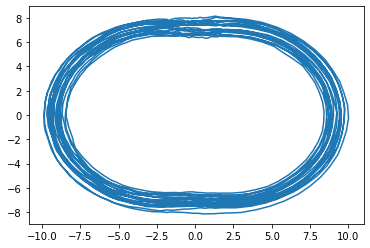

In [6]:
np.random.seed(randseed)
T = T1 + T2
x = np.random.randn(T + 1, d_latent) * 10

for t in range(T):
    x[t + 1, :] = rslds(x[t, :], A=Atrue, B=btrue, R=Rtrue, r=rtrue, K=K) + np.sqrt(varx) * np.random.randn(d_latent)

x = x[1:, :].T
plt.figure()
plt.plot(*x)
plt.show()
plt.close()

and the observation

In [7]:
C = npr.rand(d_obs, d_latent + 1) - 0.5  # parameters for emission (C = [C, D] for C*x + D
Cobs = C[:, :-1]
dobs = C[:, -1]
y = C[:, :-1] @ x + C[:, -1][:, None] + np.sqrt(vary) * npr.randn(d_obs, T)

An observation model (likelihood) is needed. Here we use isotropic Gaussian.

In [8]:
log_like = likelihood.ISOGaussian(d_obs, d_latent, log_flag=log_flag)
log_like.input_to_output.weight.data = torch.from_numpy(C[:, :-1])
log_like.input_to_output.weight.requires_grad = emission_grad  # should we learn emission distribution

log_like.input_to_output.bias.data = torch.from_numpy(C[:, -1])
log_like.input_to_output.bias.requires_grad = emission_grad  # should we learn emission distribution

log_like.tau.data.fill_(np.log(vary))
log_like.tau.requires_grad = emission_grad  # should we learn emission distribution

We place the inducing points randomly.

In [9]:
ux, uy = np.meshgrid(np.linspace(xmin, xmax, 5), np.linspace(ymin, ymax, 4))
u_inducing = np.stack([ux.ravel(), uy.ravel()]).T

Let's train the model.

In [10]:
torch.manual_seed(randseed)

r = proposal.MlpProposal(d_latent + d_obs, d_hidden, d_latent, log_flag=False)  # MLP proposal

# initial particles and weights
x_particles = 10 * torch.randn(n_pf, d_latent)
x_particles = x_particles.double()
w = np.ones(n_pf) / n_pf
x_est = np.zeros((d_latent, T1))
noise = varx

# Set up GP 
cov_func = SquaredExponential(fvar, length_scale)
cov_func.loggamma.requires_grad = False  # not optimize hyperparameter
cov_func.logvar.requires_grad = False

# GP particles
z_SS = [SGP(d_latent, d_latent, u_inducing, None,
            cov_func, noise) for n in range(n_pf)]  # Construct sparse GP objects
# rz = SGP(d_latent, d_latent, u_inducing, None, cov_func, noise)
pf = SVMC_GP(n_pf, n_optim, d_latent, d_obs, log_like, r, z_SS, lr=lr, gp_diffusion=gp_diffusion)
z_seq = SGP(d_latent, d_latent, u_inducing, None,
            cov_func, noise)

ESS = []
Z_particles = []
W = []
particles = (x_particles, np.zeros((n_pf, d_latent)), z_SS)

Y = torch.from_numpy(y.T).double()  # Convert to tensor
nongradient = False  # train GP
try:
    for t in range(T1):
        if t > Tu:
            nongradient = True
        particles, _, w = pf.filter(Y[t, :], particles, w, iter_optim, nongradient=nongradient)
        x_particles = particles[0].detach()
        # particles = (x_particles, particles[1], 0, particles[3])
        ESS.append(1 / np.sum(w ** 2))  # compute effective sample size
        for n in range(n_pf):
            x_est[:, t] += w[n] * x_particles[n, :].numpy()
        Z_particles.append(particles[2])
        W.append(w)
except KeyboardInterrupt:
    pass


Plot the inferred trajectory and velocity field.

<ipython-input-11-be554cd8f1bc>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


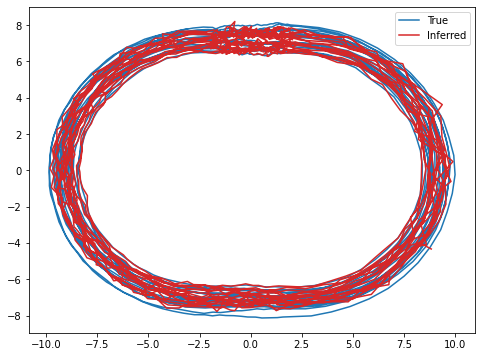

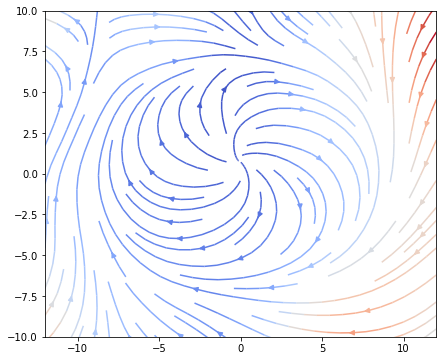

In [11]:
fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.plot(*x[:, 1:], color='tab:blue', label='True')
ax1.plot(*x_est, color='tab:red', label='Inferred')
plt.legend()
fig.show()

# Construct a mean GP using the GP particles 
sgp = svmc.gp.SGP(d_latent, d_latent, u_inducing, None, cov_func, noise)
qmean = 0
qcov = 0

for n in range(n_pf):
    qmean += w[n] * particles[2][n].qz.mean
    qcov += w[n] ** 2 * particles[2][n].qz.cov
sgp.qz.mean = qmean
sgp.qz.cov = qcov

fig1 = gp_velocity_field(sgp, None, None, [xmin, xmax], [ymin, ymax], l=xmin, u=xmax)

Forecast future states

<ipython-input-12-5ec1d262e8c0>:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


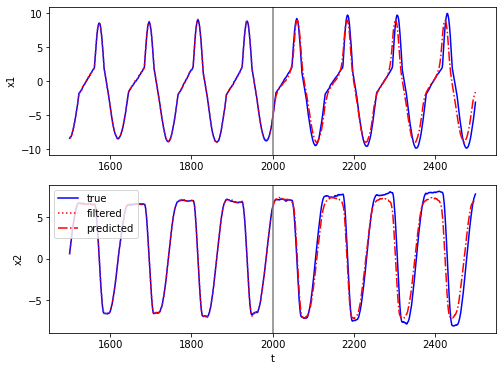

In [12]:
# Forecast future state
x_pred = np.zeros((T2 + 1, d_latent))
x_pred[0, :] = x_est[:, -1]
for t in range(T2):
    x_pred[t + 1, :] = x_pred[[t], :] + sgp.predict(x_pred[[t], :])[0].numpy() + np.random.randn(d_latent) * np.sqrt(varx)

# Plot over time
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(211)
ax.plot(np.arange(T1-500, T), x[0, -500-T2:], color='blue')

ax.plot(np.arange(T1-500, T1), x_est[0, -500:], color='red', linestyle=':')
ax.plot(np.arange(T1, T), x_pred[1:, 0], color='red', linestyle='-.')
ax.set_ylabel("x1")
ax.axvline(x=T1, ymin=-25, ymax=25, color="grey")

ax = fig.add_subplot(212)
ax.plot(np.arange(T1-500, T), x[1, -500-T2:], color='blue', label="true")
ax.plot(np.arange(T1-500, T1), x_est[1, -500:], color='red', linestyle=':', label="filtered")

ax.plot(np.arange(T1, T), x_pred[1:, 1], color='red', linestyle='-.', label="predicted")
ax.set_xlabel("t")
ax.set_ylabel("x2")
ax.axvline(x=T1, ymin=-25, ymax=25, color="grey")
ax.legend(loc="upper left")
fig.show()